<a href="https://colab.research.google.com/github/pablots98/Internship_preproc/blob/main/Data_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load the packages

In [18]:
!pip install gprofiler-official
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from gprofiler import GProfiler

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load the data

In [2]:
route = '/content/drive/My Drive/Colab Notebooks/Internship/data_TPM.xlsx'
# Load the data
data = pd.read_excel(route, engine = 'openpyxl')

# DIFERENTIAL GENE EXPRESSION ANALYSIS

Stablish the conditions (with or without senescence)

In [3]:
total_samples = list(data.columns)
total_samples.pop(0)

'Ensembl_GeneID'

In [4]:
samples_H = ['BJ_Y1', 'BJ_Y2', 'BJ_Y3', 'IMR_Y1', 'IMR_Y2', 'IMR_Y3', 'WI_38_Y1', 'WI_38_Y2', 'WI_38_Y3', 'HFF_PD16_1', 'HHFF_PD74_1', 'MRC_5_PD32', 'MRC_PD72_1', 'HHFF_PD26_1', 'HFF_PD46_1', 'HHFF_PD64_1', 'MRC_5_PD42_1', 'MRC_5_PD52_1', 'MRC_5_PD62_1']

samples_conditionS = [sample for sample in total_samples if sample not in samples_H]

Create the conditions column

In [5]:
conditions = ['Healthy' if sample in samples_H else 'Senescence' for sample in total_samples]

Transform the Dataframe

In [6]:
long_data = data.reset_index().melt(id_vars='index', var_name='Sample', value_name='Expression')
long_data['Condition'] = long_data['Sample'].map(lambda x: 'Healthy' if x in samples_H else 'Senescence')

DGEA

In [9]:
# Convertir la columna 'Expression' a numérica
long_data['Expression'] = pd.to_numeric(long_data['Expression'], errors='coerce')

# Verificar los tipos de datos después de la conversión
print(long_data.dtypes)

# Ahora continúa con tu bucle for para ajustar el modelo
results = []

for gene in data.index:
  gene_data = long_data[long_data['index'] == gene]

  # Asegúrate de que 'gene_data' no tiene filas con 'NaN' en 'Expression' antes de ajustar el modelo
  gene_data = gene_data.dropna(subset=['Expression'])

  model = smf.ols('Expression ~ Condition', data = gene_data).fit()
  results.append({
      'Gene' : gene,
      'p-value' : model.f_pvalue,
      'coef' : model.params.get('Condition[T.Senescence]', 0)
  })

results_df = pd.DataFrame(results)
print(results_df)

index           int64
Sample         object
Expression    float64
Condition      object
dtype: object


Se han truncado las últimas 5000 líneas del flujo de salida.
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/usr/local/lib/python3.1

        Gene   p-value       coef
0          0  0.007243  15.672889
1          1  0.444633   0.004089
2          2  0.444855   5.264321
3          3  0.805027  -0.127549
4          4  0.000802  -2.531085
...      ...       ...        ...
26264  26264       NaN   0.000000
26265  26265  0.370615  -0.009444
26266  26266  0.661908   0.336790
26267  26267       NaN   0.000000
26268  26268  0.564196  -0.084264

[26269 rows x 3 columns]


Multiple test correction

In [11]:
pvals = results_df['p-value'].values
_, pvals_adj, _, _ = multipletests(pvals, method = 'fdr_bh')

# Add p adjusted values to the Data Frame
results_df['p-value_adj'] = pvals_adj

Select significative genes

In [21]:
significant_genes = results_df[results_df['p-value_adj'] < 0.05]
print(significant_genes)

Empty DataFrame
Columns: [Gene, p-value, coef, p-value_adj]
Index: []


Functional enrichment analysis

In [22]:
# Lista de genes significativos
gene_list = significant_genes['Gene'].tolist()

# Inicializa g:Profiler
gp = GProfiler(return_dataframe=True)

# Realiza el análisis de enriquecimiento funcional
enrichment_results = gp.profile(organism='hsapiens', query=gene_list)

# Filtra los resultados para obtener solo enriquecimientos significativos
enrichment_results_filtered = enrichment_results[enrichment_results['p_value'] < 0.05]

print(enrichment_results_filtered)

AssertionError: query_1 is empty

Clustering and visualization analysis

In [15]:
# Verifica si significant_genes está vacío
print("Número de genes significativos:", len(significant_genes))

# Si no está vacío, verifica que los nombres de genes existan en 'data'
if len(significant_genes) > 0:
    missing_genes = [gene for gene in significant_genes['Gene'] if gene not in data.index]
    print("Genes faltantes en 'data':", missing_genes)

    # Asegúrate de que la selección se hace correctamente
    if not missing_genes:  # Solo si no hay genes faltantes
        expr_data_significant = data.loc[significant_genes['Gene']]

        # Procede con PCA como antes, asegurándote de que expr_data_significant no esté vacío
        if not expr_data_significant.empty:
            pca = PCA(n_components=2)
            principalComponents = pca.fit_transform(expr_data_significant.T)

            # Visualización
            plt.figure(figsize=(10, 7))
            sns.scatterplot(x=principalComponents[:, 0], y=principalComponents[:, 1])
            plt.title('PCA of Significantly Expressed Genes')
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            plt.show()
        else:
            print("No se encontraron datos significativos para realizar PCA.")
else:
    print("No hay genes significativos, por lo tanto, no se puede realizar PCA.")

Número de genes significativos: 0
No hay genes significativos, por lo tanto, no se puede realizar PCA.


# Next analysis


Hierachical clustering

In [23]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt


In [25]:
# Asumiendo que el primer columna de `data` contiene identificadores de genes y debe ser excluida
data_numeric = data.drop(data.columns[0], axis=1)

# Asegurándote de que todos los valores sean numéricos (floats o ints)
data_numeric = data_numeric.apply(pd.to_numeric, errors='coerce')

Hierarchical clustering

In [27]:
Z = sch.linkage(data_numeric.T, method = 'ward')

Create the dendogram

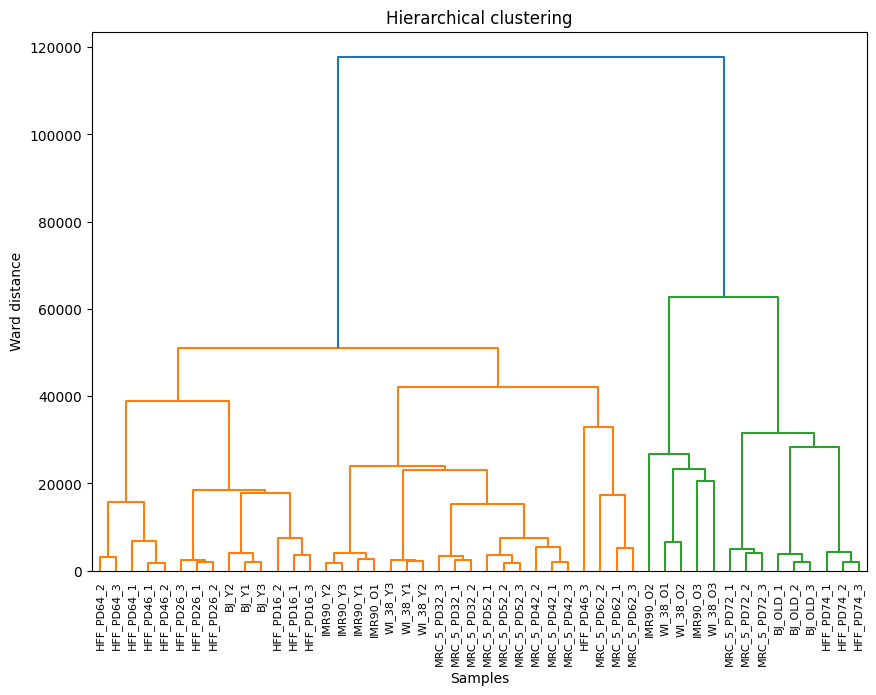

In [30]:
plt.figure(figsize=(10, 7))
D = sch.dendrogram(Z, labels=data_numeric.columns, orientation = 'top')
plt.title('Hierarchical clustering')
plt.xlabel('Samples')
plt.ylabel('Ward distance')
plt.show()

Co-expresssion network analysis

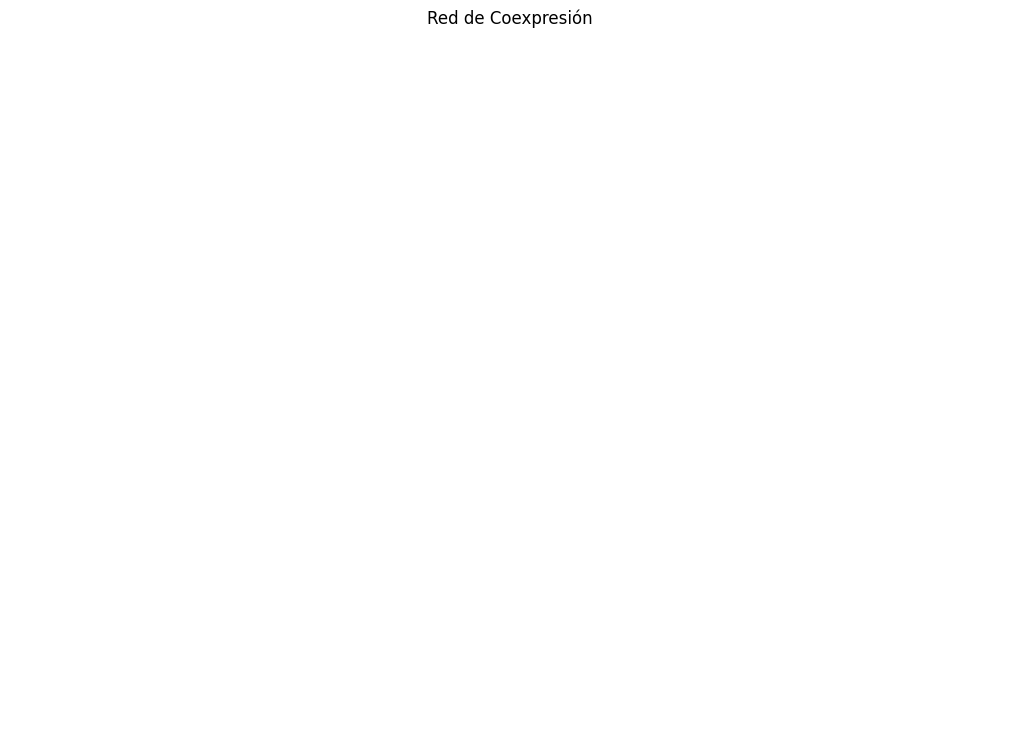

In [32]:
import networkx as nx
import seaborn as sns

# Asumiendo que el primer columna de `data` contiene identificadores de genes y debe ser excluida
data_numeric = data.drop(data.columns[0], axis=1)

# Asegurándote de que todos los valores sean numéricos (floats o ints)
data_numeric = data_numeric.apply(pd.to_numeric, errors='coerce')

# Calcular la matriz de correlación
correlation_matrix = data_numeric.corr()

# Seleccionar pares de genes con una correlación alta para simplificar
# Aquí, solo consideramos pares con una correlación > 0.8
edges = (correlation_matrix.stack()
                        .reset_index()
                        .query("level_0 < level_1 and 0 < abs(0)")
                        .loc[:, ['level_0', 'level_1']])
edges.columns = ['source', 'target']

# Construir la red
G = nx.from_pandas_edgelist(edges, 'source', 'target')

# Dibujar la red
plt.figure(figsize=(10, 7))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=700, edge_color='k')
plt.title('Red de Coexpresión')
plt.show()

Pathway analysis with g:Profiler

In [33]:
# Utilizar g:Profiler para buscar un pathway específico, asumiendo `gene_list` es tu lista de genes
resultados_pathway = gp.profile(organism='hsapiens', query=gene_list, sources=['KEGG'])

# Filtrar por un pathway específico, por ejemplo, 'hsa04110' (Ciclo celular)
pathway_especifico = resultados_pathway[resultados_pathway['native'] == 'hsa04110']

print(pathway_especifico)

AssertionError: query_1 is empty